# GTSRB Traffic Vision using PyTorch Library

## 1. setup device agnostic-code and import torch modules

In [1]:
import torch
from torch import nn 

torch.__version__

'2.4.0'

In [2]:
# setup device agnostic 
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 2. data loading and exploration

In [3]:
from torchvision import transforms, datasets

In [4]:
# setup transform function
train_transform = transforms.Compose([ 
    # resize the image to 64x64
    transforms.Resize(size=(64, 64)),
    # transform the image data into tensor 
    transforms.ToTensor()
])

test_transform = transforms.Compose([ 
    # resize the image to 64x64
    transforms.Resize(size=(64, 64)),
    # transform the image data into tensor 
    transforms.ToTensor()
])

In [5]:
train_data = datasets.GTSRB(root="data", 
                            split="train", 
                            transform=train_transform, 
                            download=True)

test_data = datasets.GTSRB(root="data",
                            split="test",
                            transform=test_transform,
                            download=True)

In [6]:
len(train_data), len(test_data)

(26640, 12630)

In [7]:
img, label = train_data[0]
img.shape, img.dtype

(torch.Size([3, 64, 64]), torch.float32)

In [8]:
# download csv file containing class labels from https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv
import requests 
from pathlib import Path 

data_csv = Path("data/signnames.csv")

if data_csv.is_file():
    print("file csv already exists!")
else: 
    print("downloading the file...")
    request = requests.get("https://raw.githubusercontent.com/georgesung/traffic_sign_classification_german/master/signnames.csv")
    with open(data_csv, "wb") as f:
        f.write(request.content)

file csv already exists!


In [9]:
# extract data from csv into list 
import csv 

with open(data_csv, newline='') as f: 
    reader = csv.reader(f) 
    class_names = [x[1] for x in reader]
    del class_names[0]

class_names, len(class_names)


(['Speed limit (20km/h)',
  'Speed limit (30km/h)',
  'Speed limit (50km/h)',
  'Speed limit (60km/h)',
  'Speed limit (70km/h)',
  'Speed limit (80km/h)',
  'End of speed limit (80km/h)',
  'Speed limit (100km/h)',
  'Speed limit (120km/h)',
  'No passing',
  'No passing for vechiles over 3.5 metric tons',
  'Right-of-way at the next intersection',
  'Priority road',
  'Yield',
  'Stop',
  'No vechiles',
  'Vechiles over 3.5 metric tons prohibited',
  'No entry',
  'General caution',
  'Dangerous curve to the left',
  'Dangerous curve to the right',
  'Double curve',
  'Bumpy road',
  'Slippery road',
  'Road narrows on the right',
  'Road work',
  'Traffic signals',
  'Pedestrians',
  'Children crossing',
  'Bicycles crossing',
  'Beware of ice/snow',
  'Wild animals crossing',
  'End of all speed and passing limits',
  'Turn right ahead',
  'Turn left ahead',
  'Ahead only',
  'Go straight or right',
  'Go straight or left',
  'Keep right',
  'Keep left',
  'Roundabout mandatory',
 

In [10]:
# visualize random 10 images
import matplotlib.pyplot as plt 
import numpy as np
import random 

def random_plot(dataset, n=10, s=17):
    random.seed(s)
    torch.manual_seed(s) 
    nrows = n//2 
    ncols = 5
    plt.figure(figsize=(12, 15))
    for i in range(n):
        random_idx = torch.randint(high=len(dataset), size=(1,)).item()
        image, label = dataset[random_idx]
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(class_names[label])    
    # Hide axis for better visualization
    plt.subplots_adjust()  # Adjust layout to prevent overlap
    plt.show()

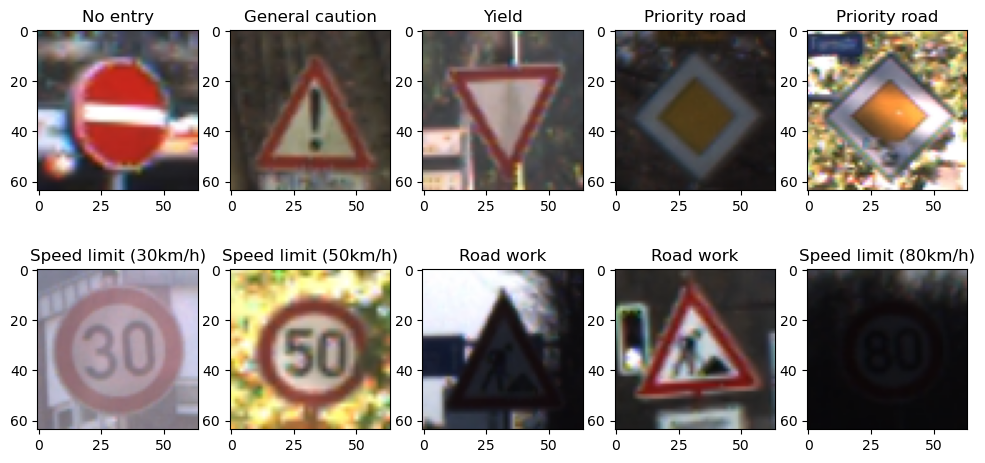

In [11]:
random_plot(dataset=train_data, s=17)

## 3. setup dataloaders

In [12]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32 

train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

len(train_dataloader), len(test_dataloader)

(833, 395)

In [13]:
img_batch, labels = next(iter(train_dataloader))

img_batch.shape, labels.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 4. setup model V0

The first model (GTSRBModelV0) will replicate LeNet-5

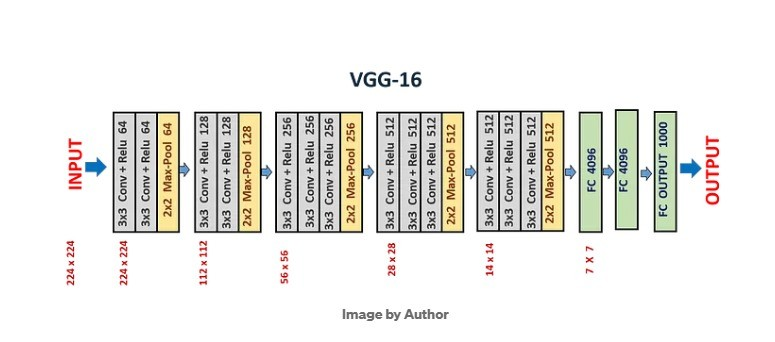
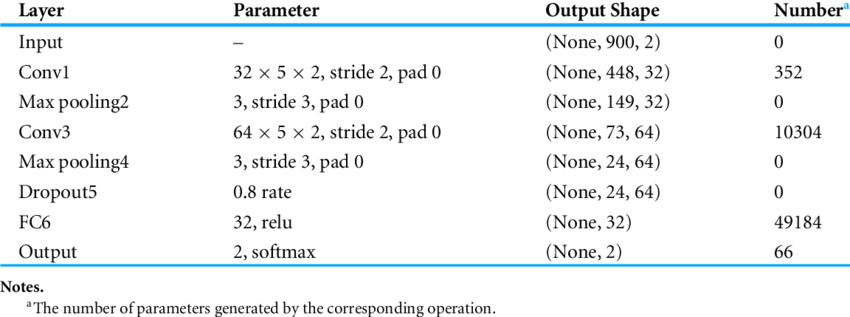


In [14]:
class GTSRBModelV0(nn.Module):
    def __init__(self, input_shape, output_shape, hidden_units=1):
        super().__init__()

        self.conv_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                        out_channels=hidden_units, 
                        kernel_size=3, 
                        stride=1, 
                        padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units, 
                        kernel_size=3, 
                        stride=1, 
                        padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) 

        self.conv_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                        out_channels=hidden_units, 
                        kernel_size=3, 
                        stride=1, 
                        padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units, 
                        kernel_size=3, 
                        stride=1, 
                        padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) 

        self.conv_layer_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                        out_channels=hidden_units, 
                        kernel_size=3, 
                        stride=1, 
                        padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                        out_channels=hidden_units, 
                        kernel_size=3, 
                        stride=1, 
                        padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) 

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8, out_features=output_shape)
        )

    def forward(self, x):
        z = self.conv_layer_1(x) 
        z = self.conv_layer_2(z)
        z = self.conv_layer_3(z) 
        z = self.classifier(z) 
        return z


In [15]:
# instantiate model_0 
torch.manual_seed(17)
torch.cuda.manual_seed(17)

model_0 = GTSRBModelV0(input_shape=3, output_shape=len(class_names), hidden_units=10)
model_0.to(device)

GTSRBModelV0(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(i

In [16]:
# setup loss function and optimizer 
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)
optimizer.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.01,
   'momentum': 0,
   'dampening': 0,
   'weight_decay': 0,
   'nesterov': False,
   'maximize': False,
   'foreach': None,
   'differentiable': False,
   'fused': None,
   'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]}

In [17]:
# setup accuracy function
from torchmetrics import Accuracy
accuracy_fn = Accuracy(task="multiclass", num_classes=len(class_names)).to(device)

In [18]:
# setup training and testing loop
from tqdm.auto import tqdm

epochs = 25

for epoch in tqdm(range(epochs)):
    model_0.train()
    # global variables for training loss and accuracy
    training_loss, training_accuracy = 0, 0
    # loop through batches 
    for batch, (X, y) in enumerate(train_dataloader):
        # send data to target device 
        X, y = X.to(device), y.to(device)
        # pass forward 
        logits = model_0(X) 
        # calculate loss 
        loss = loss_fn(logits, y)
        training_loss += loss 
        # calculate accuracy 
        training_accuracy += accuracy_fn(torch.softmax(logits, dim=1).argmax(dim=1), y)
        # zero the optimizer 
        optimizer.zero_grad()
        # perform backpropagation 
        loss.backward()
        # perform gradient descent 
        optimizer.step()

        if batch % 400 == 0: 
            print(f"looked at {BATCH_SIZE * batch}/{len(train_data)}")

    training_loss /= len(train_dataloader)
    training_accuracy /= len(train_dataloader)
        
    testing_loss, testing_accuracy = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader: 
            # send the data to target device 
            X, y = X.to(device), y.to(device)
            # pass forward 
            test_logits = model_0(X)
            # calculate testing loss 
            testing_loss += loss_fn(test_logits, y)
            # calculate testing accuracy 
            testing_accuracy += accuracy_fn(torch.softmax(test_logits, dim=1).argmax(dim=1), y)
        testing_loss /= len(test_dataloader)
        testing_accuracy /= len(test_dataloader)
    # print out what's happening 
    print(f"Epoch: {epoch} | Training loss: {training_loss:.5f}, Training accuracy: {training_accuracy:.2f} | Testing loss: {testing_loss:.5f}, Testing accuracy: {testing_accuracy:.2f}")


c:\Users\bolth\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/25 [00:00<?, ?it/s]

looked at 0/26640
looked at 12800/26640
looked at 25600/26640


  4%|▍         | 1/25 [06:34<2:37:38, 394.11s/it]

Epoch: 0 | Training loss: 3.55630, Training accuracy: 0.05 | Testing loss: 3.46537, Testing accuracy: 0.06
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


  8%|▊         | 2/25 [06:59<1:07:51, 177.04s/it]

Epoch: 1 | Training loss: 3.37882, Training accuracy: 0.10 | Testing loss: 3.50290, Testing accuracy: 0.14
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 12%|█▏        | 3/25 [07:24<39:34, 107.95s/it]  

Epoch: 2 | Training loss: 1.99206, Training accuracy: 0.48 | Testing loss: 1.46427, Testing accuracy: 0.66
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 16%|█▌        | 4/25 [07:50<26:25, 75.48s/it] 

Epoch: 3 | Training loss: 0.58573, Training accuracy: 0.85 | Testing loss: 1.07712, Testing accuracy: 0.77
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 20%|██        | 5/25 [08:15<19:04, 57.21s/it]

Epoch: 4 | Training loss: 0.30606, Training accuracy: 0.92 | Testing loss: 1.26559, Testing accuracy: 0.76
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 24%|██▍       | 6/25 [08:40<14:41, 46.39s/it]

Epoch: 5 | Training loss: 0.20898, Training accuracy: 0.95 | Testing loss: 0.82653, Testing accuracy: 0.85
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 28%|██▊       | 7/25 [09:05<11:44, 39.15s/it]

Epoch: 6 | Training loss: 0.14119, Training accuracy: 0.97 | Testing loss: 0.89859, Testing accuracy: 0.85
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 32%|███▏      | 8/25 [09:29<09:46, 34.50s/it]

Epoch: 7 | Training loss: 0.11259, Training accuracy: 0.97 | Testing loss: 0.96618, Testing accuracy: 0.82
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 36%|███▌      | 9/25 [09:54<08:24, 31.52s/it]

Epoch: 8 | Training loss: 0.08720, Training accuracy: 0.98 | Testing loss: 1.02792, Testing accuracy: 0.83
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 40%|████      | 10/25 [10:19<07:22, 29.47s/it]

Epoch: 9 | Training loss: 0.07975, Training accuracy: 0.98 | Testing loss: 0.94273, Testing accuracy: 0.86
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 44%|████▍     | 11/25 [10:44<06:31, 27.96s/it]

Epoch: 10 | Training loss: 0.06106, Training accuracy: 0.99 | Testing loss: 0.97432, Testing accuracy: 0.86
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 48%|████▊     | 12/25 [11:08<05:50, 26.94s/it]

Epoch: 11 | Training loss: 0.05657, Training accuracy: 0.99 | Testing loss: 0.89650, Testing accuracy: 0.87
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 52%|█████▏    | 13/25 [11:33<05:17, 26.46s/it]

Epoch: 12 | Training loss: 0.04379, Training accuracy: 0.99 | Testing loss: 1.06913, Testing accuracy: 0.86
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 56%|█████▌    | 14/25 [11:59<04:48, 26.23s/it]

Epoch: 13 | Training loss: 0.03961, Training accuracy: 0.99 | Testing loss: 1.07689, Testing accuracy: 0.86
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 60%|██████    | 15/25 [12:24<04:18, 25.87s/it]

Epoch: 14 | Training loss: 0.04179, Training accuracy: 0.99 | Testing loss: 0.97273, Testing accuracy: 0.86
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 64%|██████▍   | 16/25 [12:49<03:49, 25.49s/it]

Epoch: 15 | Training loss: 0.02534, Training accuracy: 0.99 | Testing loss: 1.13137, Testing accuracy: 0.87
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 68%|██████▊   | 17/25 [13:13<03:20, 25.07s/it]

Epoch: 16 | Training loss: 0.02888, Training accuracy: 0.99 | Testing loss: 1.18700, Testing accuracy: 0.85
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 72%|███████▏  | 18/25 [13:38<02:55, 25.02s/it]

Epoch: 17 | Training loss: 0.02605, Training accuracy: 0.99 | Testing loss: 1.22416, Testing accuracy: 0.86
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 76%|███████▌  | 19/25 [14:03<02:30, 25.06s/it]

Epoch: 18 | Training loss: 0.02710, Training accuracy: 0.99 | Testing loss: 1.13952, Testing accuracy: 0.85
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 80%|████████  | 20/25 [14:28<02:04, 24.93s/it]

Epoch: 19 | Training loss: 0.02735, Training accuracy: 0.99 | Testing loss: 1.04212, Testing accuracy: 0.88
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 84%|████████▍ | 21/25 [14:53<01:40, 25.02s/it]

Epoch: 20 | Training loss: 0.01521, Training accuracy: 1.00 | Testing loss: 1.12747, Testing accuracy: 0.87
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 88%|████████▊ | 22/25 [15:18<01:14, 25.00s/it]

Epoch: 21 | Training loss: 0.02127, Training accuracy: 0.99 | Testing loss: 1.00564, Testing accuracy: 0.88
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 92%|█████████▏| 23/25 [15:43<00:50, 25.10s/it]

Epoch: 22 | Training loss: 0.01511, Training accuracy: 1.00 | Testing loss: 1.16004, Testing accuracy: 0.87
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


 96%|█████████▌| 24/25 [16:09<00:25, 25.33s/it]

Epoch: 23 | Training loss: 0.03236, Training accuracy: 0.99 | Testing loss: 1.03462, Testing accuracy: 0.88
looked at 0/26640
looked at 12800/26640
looked at 25600/26640


100%|██████████| 25/25 [16:35<00:00, 39.81s/it]

Epoch: 24 | Training loss: 0.01249, Training accuracy: 1.00 | Testing loss: 1.18902, Testing accuracy: 0.87


## 5. visualize test results

In [19]:
def make_pred(model: torch.nn.Module, sample):
    model.eval()
    sample = sample.to(device)
    with torch.inference_mode():
        logits = model(sample.unsqueeze(dim=0))
    return torch.softmax(logits, dim=1).argmax(dim=1)

In [20]:
def test_plot(dataset, n=10, s=17):
    random.seed(s)
    torch.manual_seed(s) 
    nrows = n//2 
    ncols = 5
    plt.figure(figsize=(15, 20))
    for i in range(n):
        random_idx = torch.randint(high=len(dataset), size=(1,)).item()
        predicted_label = make_pred(model=model_0, sample=dataset[random_idx][0])
        image, label = dataset[random_idx]
        truth_label = label
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(image.permute(1, 2, 0))
        title = f"truth: {truth_label} | pred: {predicted_label.item()}"
        if truth_label == predicted_label:
            plt.title(title, c="g")
        else:
            plt.title(title, c="r")    
    # Hide axis for better visualization
    plt.subplots_adjust()  # Adjust layout to prevent overlap
    plt.show()

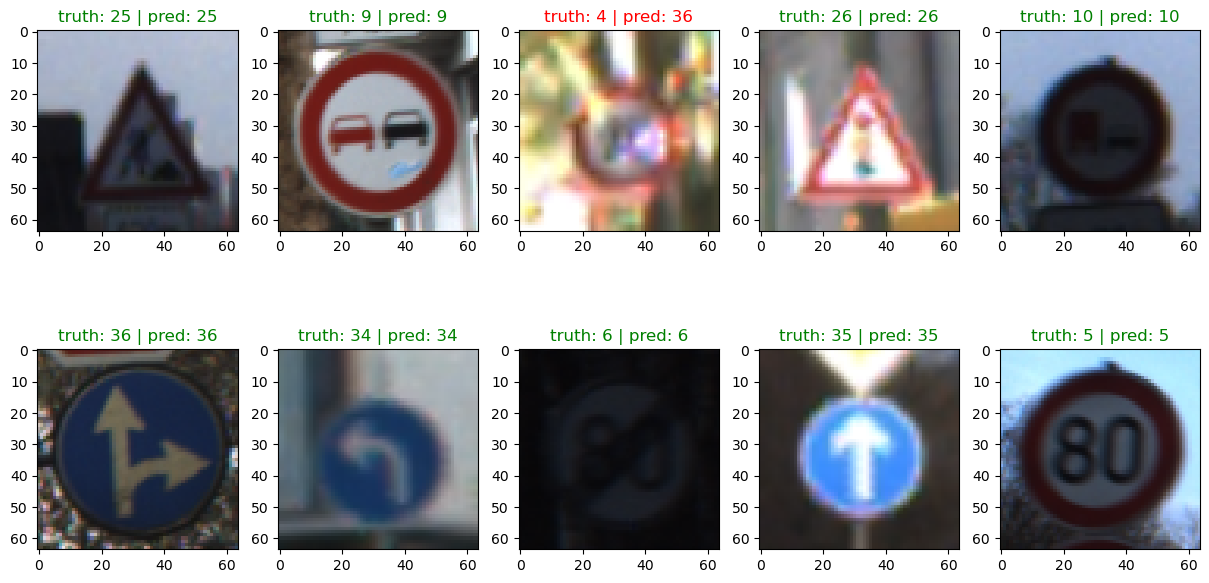

In [21]:
test_plot(dataset=test_data, s=20)

### 5.1 save and load the model

In [22]:
# saving the model
from pathlib import Path 

MODEL_DIR = Path("models")
MODEL_NAME = "GTSRBModelV0.pt"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

SAVE_PATH = MODEL_DIR / MODEL_NAME
torch.save(model_0.state_dict(), f=SAVE_PATH)

In [23]:
# load the model
loaded_v0 = GTSRBModelV0(input_shape=3, output_shape=len(class_names), hidden_units=10)
loaded_v0.load_state_dict(torch.load(f=SAVE_PATH))
loaded_v0.to(device)

C:\Users\bolth\AppData\Local\Temp\ipykernel_9860\2349523079.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_v0.load_state_dict(torch.load(f=SAVE_PATH))


GTSRBModelV0(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_3): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(i

## 6. Model evaluation and metrics calculation